# Pre-Processing & Setup

## GPU, Imports & Load Data

In [ ]:
# ============================================================================
# TAMIL SQUAD TRANSLATION - 7-PART APPROACH WITH QUALITY REVIEW
# Complete 130K dataset | VS Code | RTX 4070 8GB
# ============================================================================

# ============================================================================
# CELL 1: GPU CHECK
# ============================================================================

import torch

print("GPU CHECK")
print("="*80)

if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available!")

device = "cuda"
gpu_name = torch.cuda.get_device_name(0)
gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)

print(f"GPU: {gpu_name}")
print(f"VRAM: {gpu_memory:.1f} GB")
print(f"CUDA: {torch.version.cuda}")
print(f"Device: {device}")
print("="*80)

In [ ]:
# ============================================================================
# CELL 2: IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.cuda.amp import autocast
from tqdm import tqdm
import warnings
import gc
from datetime import datetime
warnings.filterwarnings('ignore')

print("Libraries imported")

In [ ]:
# ============================================================================
# CELL 3: LOAD CSV FILES
# ============================================================================

print("\nLOADING DATA")
print("="*80)

TRAIN_CSV = "squad2_train.csv"
DEV_CSV = "squad2_dev.csv"

df_train_full = pd.read_csv(TRAIN_CSV)
df_dev_full = pd.read_csv(DEV_CSV)

print(f"Train: {len(df_train_full):,} rows")
print(f"Dev: {len(df_dev_full):,} rows")
print("="*80)

## 7 Parts with 1st part 10k, and 6-20k parts split into 5 parts.

In [ ]:
# ============================================================================
# CELL 4: SPLIT TRAIN INTO 7 PARTS
# ============================================================================

print("\nSPLITTING TRAIN DATA INTO 7 PARTS")
print("="*80)

# Define splits
splits = [
    ('A', 0, 10000, 10000),
    ('B', 10000, 30000, 20000),
    ('C', 30000, 50000, 20000),
    ('D', 50000, 70000, 20000),
    ('E', 70000, 90000, 20000),
    ('F', 90000, 110000, 20000),
    ('G', 110000, 130319, 20319)
]

# Create part DataFrames
parts = {}
for part_name, start, end, size in splits:
    parts[part_name] = df_train_full.iloc[start:end].copy()
    print(f"Part {part_name}: Rows {start:,}-{end-1:,} ({size:,} rows)")

print(f"\nTotal: {sum([s[3] for s in splits]):,} rows")
print("="*80)

## Configurations, Model and Translation Function

In [ ]:
# ============================================================================
# CELL 5: CONFIGURATION
# ============================================================================

BATCH_SIZE = 64
MAX_LENGTH = 384
TARGET_LANG = "tam_Taml"
SOURCE_LANG = "eng_Latn"
MODEL_NAME = "facebook/nllb-200-distilled-600M"

print("\nCONFIGURATION")
print("="*80)
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Length: {MAX_LENGTH}")
print(f"Model: {MODEL_NAME}")
print(f"Target: Tamil")
print("="*80)

In [ ]:
# ============================================================================
# CELL 6: LOAD MODEL
# ============================================================================

print("\nLOADING MODEL")
print("="*80)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
)

model.to(device)
model.eval()

print(f"Model on {device}")

# GPU optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

print("GPU optimizations enabled")
print("="*80)

In [ ]:
# ============================================================================
# CELL 7: TRANSLATION FUNCTIONS
# ============================================================================

@torch.inference_mode()
def translate_batch(texts, target_lang, source_lang="eng_Latn"):
    valid_texts = [str(t) if pd.notna(t) and str(t).strip() != "" else "" for t in texts]
    
    indices_to_translate = [i for i, t in enumerate(valid_texts) if t != ""]
    texts_to_translate = [valid_texts[i] for i in indices_to_translate]
    
    if not texts_to_translate:
        return valid_texts
    
    tokenizer.src_lang = source_lang
    inputs = tokenizer(
        texts_to_translate,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    forced_bos_token_id = tokenizer.convert_tokens_to_ids(target_lang)
    
    with autocast(dtype=torch.float16):
        translated_tokens = model.generate(
            **inputs,
            forced_bos_token_id=forced_bos_token_id,
            max_length=MAX_LENGTH,
            num_beams=1,
            do_sample=False,
            use_cache=True,
        )
    
    translations = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
    
    result = valid_texts.copy()
    for idx, translation in zip(indices_to_translate, translations):
        result[idx] = translation
    
    return result


def translate_dataframe(df, part_name, output_file, batch_size=BATCH_SIZE):
    print(f"\nTRANSLATING PART {part_name}")
    print("="*80)
    print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
    
    num_batches = (len(df) + batch_size - 1) // batch_size
    
    df_tamil = df.copy()
    df_tamil['context_tamil'] = ""
    df_tamil['question_tamil'] = ""
    df_tamil['answer_text_tamil'] = ""
    df_tamil['plausible_answer_text_tamil'] = ""
    
    columns_to_translate = [
        ('context', 'context_tamil'),
        ('question', 'question_tamil'),
        ('answer_text', 'answer_text_tamil'),
        ('plausible_answer_text', 'plausible_answer_text_tamil')
    ]
    
    start_time = datetime.now()
    
    for source_col, target_col in columns_to_translate:
        print(f"\nTranslating: {source_col}")
        
        for batch_idx in tqdm(range(num_batches), desc=f"{source_col}"):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(df))
            
            batch_texts = df[source_col].iloc[start_idx:end_idx].tolist()
            translations = translate_batch(batch_texts, TARGET_LANG, SOURCE_LANG)
            df_tamil.loc[df_tamil.index[start_idx:end_idx], target_col] = translations
            
            if batch_idx % 50 == 0 and batch_idx > 0:
                torch.cuda.empty_cache()
    
    df_tamil.to_csv(output_file, index=False, encoding='utf-8-sig')
    
    elapsed = (datetime.now() - start_time).total_seconds()
    
    print(f"\nPART {part_name} COMPLETE")
    print(f"Time: {elapsed/60:.1f} min")
    print(f"Saved: {output_file}")
    print("="*80)
    
    return df_tamil

print("Functions defined")

In [ ]:
# ============================================================================
# CELL 8: QUICK SUMMARY (OPTIONAL - BEFORE TRANSLATION)
# ============================================================================

print("\nQUICK DATA SUMMARY")
print("="*80)

sample = df_train_full.iloc[0]
print(f"Sample row from train:")
print(f"  Article: {sample['article_title']}")
print(f"  Question: {sample['question'][:80]}...")
print(f"  Answer: {sample['answer_text'][:50] if pd.notna(sample['answer_text']) else 'N/A'}...")

print(f"\nAvg context length: {df_train_full['context'].str.len().mean():.0f} chars")
print(f"Avg question length: {df_train_full['question'].str.len().mean():.0f} chars")

print("\n" + "="*80)
print("Ready to translate!")
print("="*80)

# Translation Runs

## 9A

In [ ]:
# ============================================================================
# CELL 9A: TRANSLATE PART A (10K) - WITH QUALITY REVIEW
# ============================================================================

print(f"\n{'='*80}")
print("PART A - QUALITY REVIEW CHECKPOINT")
print("="*80)

df_partA_tamil = translate_dataframe(
    parts['A'], 
    'A', 
    'train_tamil_partA.csv', 
    BATCH_SIZE
)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9A-REVIEW: COMPREHENSIVE QUALITY CHECK ON PART A
# ============================================================================

print("\n" + "="*80)
print("QUALITY REVIEW - PART A (10,000 SAMPLES)")
print("="*80)

# ============================================================================
# 1. ROW COUNT VERIFICATION
# ============================================================================
print("\n1. ROW COUNT VERIFICATION:")
part_a_original = len(parts['A'])
part_a_translated = len(df_partA_tamil)
print(f"   Original Part A: {part_a_original:,} rows")
print(f"   Translated Part A: {part_a_translated:,} rows")
print(f"   Difference: {part_a_original - part_a_translated:,}")

if part_a_original == part_a_translated:
    print("   ✅ Row counts match perfectly")
else:
    print("   ❌ CRITICAL: Row count mismatch!")

# ============================================================================
# 2. COLUMN VERIFICATION
# ============================================================================
print("\n2. COLUMN VERIFICATION:")
expected_new_cols = ['context_tamil', 'question_tamil', 'answer_text_tamil', 'plausible_answer_text_tamil']
actual_new_cols = [col for col in df_partA_tamil.columns if 'tamil' in col.lower()]

print(f"   Expected: {expected_new_cols}")
print(f"   Found: {actual_new_cols}")

if set(expected_new_cols).issubset(set(actual_new_cols)):
    print("   ✅ All Tamil columns created")
else:
    missing = set(expected_new_cols) - set(actual_new_cols)
    print(f"   ❌ CRITICAL: Missing columns: {missing}")

# ============================================================================
# 3. EMPTY/NULL TRANSLATION CHECK
# ============================================================================
print("\n3. EMPTY TRANSLATION CHECK:")

empty_contexts = (df_partA_tamil['context_tamil'].isna() | 
                  (df_partA_tamil['context_tamil'] == '')).sum()
empty_questions = (df_partA_tamil['question_tamil'].isna() | 
                   (df_partA_tamil['question_tamil'] == '')).sum()
empty_answers = (df_partA_tamil['answer_text_tamil'].isna() | 
                 (df_partA_tamil['answer_text_tamil'] == '')).sum()

print(f"   Empty contexts: {empty_contexts:,} ({empty_contexts/len(df_partA_tamil)*100:.2f}%)")
print(f"   Empty questions: {empty_questions:,} ({empty_questions/len(df_partA_tamil)*100:.2f}%)")
print(f"   Empty answers: {empty_answers:,} ({empty_answers/len(df_partA_tamil)*100:.2f}%)")

if empty_contexts == 0 and empty_questions == 0:
    print("   ✅ No critical empty translations")
elif empty_contexts + empty_questions < 10:
    print("   ⚠️  Minor: Few empty translations (acceptable)")
else:
    print("   ❌ CRITICAL: Too many empty translations!")

# ============================================================================
# 4. ORIGINAL DATA PRESERVATION CHECK
# ============================================================================
print("\n4. ORIGINAL DATA PRESERVATION:")

# Check if original columns exist and unchanged
original_cols_check = ['context', 'question', 'answer_text', 'article_title']
preserved = all(col in df_partA_tamil.columns for col in original_cols_check)

print(f"   Original columns present: {preserved}")

if preserved:
    # Check if data actually unchanged (compare first row)
    orig_first = parts['A'].iloc[0]['context']
    trans_first = df_partA_tamil.iloc[0]['context']
    
    if orig_first == trans_first:
        print("   ✅ Original English data preserved")
    else:
        print("   ❌ CRITICAL: Original data modified!")
else:
    print("   ❌ CRITICAL: Original columns missing!")

# ============================================================================
# 5. LENGTH RATIO ANALYSIS
# ============================================================================
print("\n5. LENGTH RATIO ANALYSIS:")

df_partA_tamil['context_len'] = df_partA_tamil['context'].str.len()
df_partA_tamil['context_tamil_len'] = df_partA_tamil['context_tamil'].str.len()
df_partA_tamil['question_len'] = df_partA_tamil['question'].str.len()
df_partA_tamil['question_tamil_len'] = df_partA_tamil['question_tamil'].str.len()

df_partA_tamil['context_ratio'] = df_partA_tamil['context_tamil_len'] / df_partA_tamil['context_len']
df_partA_tamil['question_ratio'] = df_partA_tamil['question_tamil_len'] / df_partA_tamil['question_len']

context_ratio_median = df_partA_tamil['context_ratio'].median()
context_ratio_mean = df_partA_tamil['context_ratio'].mean()
question_ratio_median = df_partA_tamil['question_ratio'].median()
question_ratio_mean = df_partA_tamil['question_ratio'].mean()

print(f"   Context ratio (Tamil/English):")
print(f"      Median: {context_ratio_median:.2f}x")
print(f"      Mean: {context_ratio_mean:.2f}x")
print(f"      Range: {df_partA_tamil['context_ratio'].min():.2f}x - {df_partA_tamil['context_ratio'].max():.2f}x")

print(f"   Question ratio (Tamil/English):")
print(f"      Median: {question_ratio_median:.2f}x")
print(f"      Mean: {question_ratio_mean:.2f}x")
print(f"      Range: {df_partA_tamil['question_ratio'].min():.2f}x - {df_partA_tamil['question_ratio'].max():.2f}x")

if 0.8 < context_ratio_median < 2.0 and 0.8 < question_ratio_median < 2.0:
    print("   ✅ Ratios look normal")
elif 0.5 < context_ratio_median < 2.5:
    print("   ⚠️  Ratios slightly unusual but acceptable")
else:
    print("   ❌ WARNING: Unusual ratios - check translations!")

# ============================================================================
# 6. CHARACTER SET VALIDATION
# ============================================================================
print("\n6. CHARACTER SET VALIDATION:")

# Check for Tamil Unicode characters
import re
tamil_pattern = re.compile(r'[\u0B80-\u0BFF]+')  # Tamil Unicode range

contexts_with_tamil = df_partA_tamil['context_tamil'].apply(lambda x: bool(tamil_pattern.search(str(x)))).sum()
questions_with_tamil = df_partA_tamil['question_tamil'].apply(lambda x: bool(tamil_pattern.search(str(x)))).sum()

print(f"   Contexts with Tamil script: {contexts_with_tamil:,}/{len(df_partA_tamil):,} ({contexts_with_tamil/len(df_partA_tamil)*100:.1f}%)")
print(f"   Questions with Tamil script: {questions_with_tamil:,}/{len(df_partA_tamil):,} ({questions_with_tamil/len(df_partA_tamil)*100:.1f}%)")

if contexts_with_tamil > len(df_partA_tamil) * 0.95:
    print("   ✅ Tamil characters detected in most rows")
else:
    print("   ❌ WARNING: Many rows missing Tamil characters!")

# Check for English characters remaining in Tamil columns
english_pattern = re.compile(r'[a-zA-Z]{5,}')  # 5+ consecutive English letters
contexts_with_english = df_partA_tamil['context_tamil'].apply(lambda x: bool(english_pattern.search(str(x)))).sum()
questions_with_english = df_partA_tamil['question_tamil'].apply(lambda x: bool(english_pattern.search(str(x)))).sum()

print(f"\n   English words in Tamil contexts: {contexts_with_english:,} ({contexts_with_english/len(df_partA_tamil)*100:.1f}%)")
print(f"   English words in Tamil questions: {questions_with_english:,} ({questions_with_english/len(df_partA_tamil)*100:.1f}%)")

if contexts_with_english < len(df_partA_tamil) * 0.1:
    print("   ✅ Minimal English in Tamil columns (names/entities expected)")
else:
    print("   ⚠️  High English content in Tamil columns")

# ============================================================================
# 7. DUPLICATE CHECK
# ============================================================================
print("\n7. DUPLICATE CHECK:")

orig_dupes = parts['A'].duplicated().sum()
trans_dupes = df_partA_tamil.duplicated().sum()

print(f"   Duplicates in original: {orig_dupes:,}")
print(f"   Duplicates in translated: {trans_dupes:,}")

if orig_dupes == trans_dupes:
    print("   ✅ Duplicate count unchanged")
else:
    print("   ⚠️  Duplicate count changed (may be okay)")

# ============================================================================
# 8. SAMPLE TRANSLATIONS (VISUAL CHECK)
# ============================================================================
print("\n8. SAMPLE TRANSLATIONS (MANUAL REVIEW):")
print("="*80)

# Samples from different parts of Part A
sample_indices = [0, 2500, 5000, 7500, 9999]

for idx in sample_indices:
    row = df_partA_tamil.iloc[idx]
    print(f"\n📌 Sample {idx+1} (Row {idx}):")
    print(f"   Article: {row['article_title']}")
    
    print(f"\n   English Context (first 150 chars):")
    print(f"      {row['context'][:150]}...")
    print(f"   Tamil Context (first 150 chars):")
    print(f"      {row['context_tamil'][:150]}...")
    
    print(f"\n   English Question:")
    print(f"      {row['question']}")
    print(f"   Tamil Question:")
    print(f"      {row['question_tamil']}")
    
    print(f"\n   English Answer:")
    print(f"      {row['answer_text'] if pd.notna(row['answer_text']) else 'N/A'}")
    print(f"   Tamil Answer:")
    print(f"      {row['answer_text_tamil'] if pd.notna(row['answer_text_tamil']) else 'N/A'}")
    
    print(f"\n   Impossible: {row['is_impossible']}")
    print(f"   Length ratios: Context={row['context_ratio']:.2f}x, Question={row['question_ratio']:.2f}x")
    print("-"*80)

# ============================================================================
# 9. VERIFICATION SUMMARY
# ============================================================================
print("\n" + "="*80)
print("VERIFICATION SUMMARY - PART A")
print("="*80)

checks = {
    'Row count matches': part_a_original == part_a_translated,
    'All columns created': set(expected_new_cols).issubset(set(actual_new_cols)),
    'No critical empty translations': empty_contexts == 0 and empty_questions == 0,
    'Original data preserved': preserved,
    'Length ratios normal': 0.8 < context_ratio_median < 2.0,
    'Tamil characters present': contexts_with_tamil > len(df_partA_tamil) * 0.95
}

passed = sum(checks.values())
total = len(checks)

print(f"\nAutomated checks passed: {passed}/{total}\n")

for check_name, result in checks.items():
    status = "✅ PASS" if result else "❌ FAIL"
    print(f"  {status}: {check_name}")

print("\n" + "="*80)

if passed == total:
    print("🎉 ALL AUTOMATED CHECKS PASSED!")
    print("="*80)
    print("\n👀 NOW DO MANUAL REVIEW:")
    print("   1. Read the 5 sample translations above")
    print("   2. Verify Tamil looks correct (not gibberish)")
    print("   3. Verify Tamil characters render properly")
    print("   4. Verify translations make sense")
    print("\n✅ If manual review GOOD → Continue to Cell 9B")
    print("❌ If manual review BAD  → Stop and debug")
else:
    print("❌ SOME AUTOMATED CHECKS FAILED")
    print("="*80)
    print("\n⚠️  DO NOT CONTINUE - FIX ISSUES FIRST:")
    print("   1. Review failed checks above")
    print("   2. Debug the translation code")
    print("   3. Re-run Cell 9A")
    print("   4. Re-run this review cell")
    print("\n❌ DO NOT proceed to Cell 9B until all checks pass")

print("\n" + "="*80)

In [ ]:
# ============================================================================
# CELL 9B-SPLIT: SPLIT REMAINING PARTS INTO SUB-PARTS
# ============================================================================

print("\nSPLITTING REMAINING PARTS FOR THERMAL MANAGEMENT")
print("="*80)

# Split Part B (20K) into 5 sub-parts of 4K each
parts_B = {
    'B1': parts['B'].iloc[0:4000].copy(),
    'B2': parts['B'].iloc[4000:8000].copy(),
    'B3': parts['B'].iloc[8000:12000].copy(),
    'B4': parts['B'].iloc[12000:16000].copy(),
    'B5': parts['B'].iloc[16000:20000].copy()
}

# Split Part C (20K) into 5 sub-parts of 4K each
parts_C = {
    'C1': parts['C'].iloc[0:4000].copy(),
    'C2': parts['C'].iloc[4000:8000].copy(),
    'C3': parts['C'].iloc[8000:12000].copy(),
    'C4': parts['C'].iloc[12000:16000].copy(),
    'C5': parts['C'].iloc[16000:20000].copy()
}

# Split Part D (20K) into 5 sub-parts of 4K each
parts_D = {
    'D1': parts['D'].iloc[0:4000].copy(),
    'D2': parts['D'].iloc[4000:8000].copy(),
    'D3': parts['D'].iloc[8000:12000].copy(),
    'D4': parts['D'].iloc[12000:16000].copy(),
    'D5': parts['D'].iloc[16000:20000].copy()
}

# Split Part E (20K) into 5 sub-parts of 4K each
parts_E = {
    'E1': parts['E'].iloc[0:4000].copy(),
    'E2': parts['E'].iloc[4000:8000].copy(),
    'E3': parts['E'].iloc[8000:12000].copy(),
    'E4': parts['E'].iloc[12000:16000].copy(),
    'E5': parts['E'].iloc[16000:20000].copy()
}

# Split Part F (20K) into 5 sub-parts of 4K each
parts_F = {
    'F1': parts['F'].iloc[0:4000].copy(),
    'F2': parts['F'].iloc[4000:8000].copy(),
    'F3': parts['F'].iloc[8000:12000].copy(),
    'F4': parts['F'].iloc[12000:16000].copy(),
    'F5': parts['F'].iloc[16000:20000].copy()
}

# Split Part G (20,319) into 5 sub-parts
parts_G = {
    'G1': parts['G'].iloc[0:4063].copy(),
    'G2': parts['G'].iloc[4063:8126].copy(),
    'G3': parts['G'].iloc[8126:12189].copy(),
    'G4': parts['G'].iloc[12189:16252].copy(),
    'G5': parts['G'].iloc[16252:20319].copy()
}

# Split Dev (11,873) into 3 sub-parts
parts_Dev = {
    'Dev1': df_dev_full.iloc[0:3957].copy(),
    'Dev2': df_dev_full.iloc[3957:7914].copy(),
    'Dev3': df_dev_full.iloc[7914:11873].copy()
}

print("\nPart B sub-parts:")
for name, df in parts_B.items():
    print(f"  {name}: {len(df):,} rows")

print("\nPart C sub-parts:")
for name, df in parts_C.items():
    print(f"  {name}: {len(df):,} rows")

print("\nPart D sub-parts:")
for name, df in parts_D.items():
    print(f"  {name}: {len(df):,} rows")

print("\nPart E sub-parts:")
for name, df in parts_E.items():
    print(f"  {name}: {len(df):,} rows")

print("\nPart F sub-parts:")
for name, df in parts_F.items():
    print(f"  {name}: {len(df):,} rows")

print("\nPart G sub-parts:")
for name, df in parts_G.items():
    print(f"  {name}: {len(df):,} rows")

print("\nDev sub-parts:")
for name, df in parts_Dev.items():
    print(f"  {name}: {len(df):,} rows")

print("\n" + "="*80)
print("SPLITTING COMPLETE - Ready for thermal-safe translation")
print("="*80)

## 9B

In [ ]:
# ============================================================================
# CELL 9B: TRANSLATE PART B (20K)
# ============================================================================

# Cell 9B1
df_partB1_tamil = translate_dataframe(parts_B['B1'], 'B1', 'train_tamil_partB1.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9B: TRANSLATE PART B (20K)
# ============================================================================

# Cell 9B2
df_partB2_tamil = translate_dataframe(parts_B['B2'], 'B2', 'train_tamil_partB2.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9B: TRANSLATE PART B (20K)
# ============================================================================

# Cell 9B3
df_partB3_tamil = translate_dataframe(parts_B['B3'], 'B3', 'train_tamil_partB3.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9B: TRANSLATE PART B (20K)
# ============================================================================

# Cell 9B4
df_partB4_tamil = translate_dataframe(parts_B['B4'], 'B4', 'train_tamil_partB4.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9B: TRANSLATE PART B (20K)
# ============================================================================

# Cell 9B5
df_partB5_tamil = translate_dataframe(parts_B['B5'], 'B5', 'train_tamil_partB5.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

## 9C

In [ ]:
# ============================================================================
# CELL 9C: TRANSLATE PART C (20K)
# ============================================================================

# Cell 9C1
df_partC1_tamil = translate_dataframe(parts_C['C1'], 'C1', 'train_tamil_partC1.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()


In [ ]:
# ============================================================================
# CELL 9C: TRANSLATE PART C (20K)
# ============================================================================

# Cell 9C2
df_partC2_tamil = translate_dataframe(parts_C['C2'], 'C2', 'train_tamil_partC2.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9C: TRANSLATE PART C (20K)
# ============================================================================

# Cell 9C3
df_partC3_tamil = translate_dataframe(parts_C['C3'], 'C3', 'train_tamil_partC3.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9C: TRANSLATE PART C (20K)
# ============================================================================

# Cell 9C4
df_partC4_tamil = translate_dataframe(parts_C['C4'], 'C4', 'train_tamil_partC4.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9C: TRANSLATE PART C (20K)
# ============================================================================

# Cell 9C5
df_partC5_tamil = translate_dataframe(parts_C['C5'], 'C5', 'train_tamil_partC5.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

## 9D

In [ ]:
# ============================================================================
# CELL 9D: TRANSLATE PART D (20K)
# ============================================================================

# Cell 9D1
df_partD1_tamil = translate_dataframe(parts_D['D1'], 'D1', 'train_tamil_partD1.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9D: TRANSLATE PART D (20K)
# ============================================================================

# Cell 9D2
df_partD2_tamil = translate_dataframe(parts_D['D2'], 'D2', 'train_tamil_partD2.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9D: TRANSLATE PART D (20K)
# ============================================================================

# Cell 9D3
df_partD3_tamil = translate_dataframe(parts_D['D3'], 'D3', 'train_tamil_partD3.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9D: TRANSLATE PART D (20K)
# ============================================================================

# Cell 9D4
df_partD4_tamil = translate_dataframe(parts_D['D4'], 'D4', 'train_tamil_partD4.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9D: TRANSLATE PART D (20K)
# ============================================================================

# Cell 9D5
df_partD5_tamil = translate_dataframe(parts_D['D5'], 'D5', 'train_tamil_partD5.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

## 9E

In [ ]:
# ============================================================================
# CELL 9E: TRANSLATE PART E (20K)
# ============================================================================

# Cell 9E1
df_partE1_tamil = translate_dataframe(parts_E['E1'], 'E1', 'train_tamil_partE1.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9E: TRANSLATE PART E (20K)
# ============================================================================

# Cell 9E2
df_partE2_tamil = translate_dataframe(parts_E['E2'], 'E2', 'train_tamil_partE2.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9E: TRANSLATE PART E (20K)
# ============================================================================

# Cell 9E3
df_partE3_tamil = translate_dataframe(parts_E['E3'], 'E3', 'train_tamil_partE3.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9E: TRANSLATE PART E (20K)
# ============================================================================

# Cell 9E4
df_partE4_tamil = translate_dataframe(parts_E['E4'], 'E4', 'train_tamil_partE4.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9E: TRANSLATE PART E (20K)
# ============================================================================

# Cell 9E5
df_partE5_tamil = translate_dataframe(parts_E['E5'], 'E5', 'train_tamil_partE5.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

## 9F

In [ ]:
# ============================================================================
# CELL 9F: TRANSLATE PART F (20K)
# ============================================================================

# Cell 9F1
df_partF1_tamil = translate_dataframe(parts_F['F1'], 'F1', 'train_tamil_partF1.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9F: TRANSLATE PART F (20K)
# ============================================================================

# Cell 9F2
df_partF2_tamil = translate_dataframe(parts_F['F2'], 'F2', 'train_tamil_partF2.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9F: TRANSLATE PART F (20K)
# ============================================================================

# Cell 9F3
df_partF3_tamil = translate_dataframe(parts_F['F3'], 'F3', 'train_tamil_partF3.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9F: TRANSLATE PART F (20K)
# ============================================================================

# Cell 9F4
df_partF4_tamil = translate_dataframe(parts_F['F4'], 'F4', 'train_tamil_partF4.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9F: TRANSLATE PART F (20K)
# ============================================================================

# Cell 9F5
df_partF5_tamil = translate_dataframe(parts_F['F5'], 'F5', 'train_tamil_partF5.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

## 9G

In [ ]:
# ============================================================================
# CELL 9G: TRANSLATE PART G (20,319)
# ============================================================================

# Cell 9G1
df_partG1_tamil = translate_dataframe(parts_G['G1'], 'G1', 'train_tamil_partG1.csv', BATCH_SIZE)


torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9G: TRANSLATE PART G (20,319)
# ============================================================================

# Cell 9G2
df_partG2_tamil = translate_dataframe(parts_G['G2'], 'G2', 'train_tamil_partG2.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9G: TRANSLATE PART G (20,319)
# ============================================================================

# Cell 9G3
df_partG3_tamil = translate_dataframe(parts_G['G3'], 'G3', 'train_tamil_partG3.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9G: TRANSLATE PART G (20,319)
# ============================================================================

# Cell 9G4
df_partG4_tamil = translate_dataframe(parts_G['G4'], 'G4', 'train_tamil_partG4.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ============================================================================
# CELL 9G: TRANSLATE PART G (20,319)
# ============================================================================

# Cell 9G5
df_partG5_tamil = translate_dataframe(parts_G['G5'], 'G5', 'train_tamil_partG5.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

In [ ]:
print("\n" + "="*80)
print("ALL TRAIN PARTS COMPLETE!")
print("="*80)

## Dev

In [ ]:
print("\nTRANSLATING DEV SPLIT - Part 1")
print("="*80)

# Cell 9Dev1
df_partDev1_tamil = translate_dataframe(parts_Dev['Dev1'], 'Dev1', 'dev_tamil_partDev1.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

print(f"\nDev complete: {len(df_partDev1_tamil):,} rows")

In [ ]:
print("\nTRANSLATING DEV SPLIT - Part 2")
print("="*80)

# Cell 9Dev2
df_partDev2_tamil = translate_dataframe(parts_Dev['Dev2'], 'Dev2', 'dev_tamil_partDev2.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

print(f"\nDev complete: {len(df_partDev2_tamil):,} rows")

In [ ]:
print("\nTRANSLATING DEV SPLIT - Part 3")
print("="*80)

# Cell 9Dev3
df_partDev3_tamil = translate_dataframe(parts_Dev['Dev3'], 'Dev3', 'dev_tamil_partDev3.csv', BATCH_SIZE)

torch.cuda.empty_cache()
gc.collect()

print(f"\nDev complete: {len(df_partDev3_tamil):,} rows")

# Post-Processing

## Concatenate

In [ ]:
# ============================================================================
# CELL 11: CONCATENATE ALL SUB-PARTS
# ============================================================================

print("\nCONCATENATING ALL PARTS")
print("="*80)

# Concatenate train parts
df_train_tamil_complete = pd.concat([
    df_partA_tamil,
    df_partB1_tamil, df_partB2_tamil, df_partB3_tamil, df_partB4_tamil, df_partB5_tamil,
    df_partC1_tamil, df_partC2_tamil, df_partC3_tamil, df_partC4_tamil, df_partC5_tamil,
    df_partD1_tamil, df_partD2_tamil, df_partD3_tamil, df_partD4_tamil, df_partD5_tamil,
    df_partE1_tamil, df_partE2_tamil, df_partE3_tamil, df_partE4_tamil, df_partE5_tamil,
    df_partF1_tamil, df_partF2_tamil, df_partF3_tamil, df_partF4_tamil, df_partF5_tamil,
    df_partG1_tamil, df_partG2_tamil, df_partG3_tamil, df_partG4_tamil, df_partG5_tamil
], ignore_index=True)

# Concatenate dev parts
df_dev_tamil_complete = pd.concat([
    df_partDev1_tamil,
    df_partDev2_tamil,
    df_partDev3_tamil
], ignore_index=True)

# Save
df_train_tamil_complete.to_csv('squad2_train_tamil_complete.csv', index=False, encoding='utf-8-sig')
df_dev_tamil_complete.to_csv('squad2_dev_tamil_complete.csv', index=False, encoding='utf-8-sig')

print(f"Train: {len(df_train_tamil_complete):,} rows")
print(f"Dev: {len(df_dev_tamil_complete):,} rows")
print("="*80)

In [ ]:
# ============================================================================
# CELL 12: FINAL STATISTICS
# ============================================================================

print("\nFINAL STATISTICS")
print("="*80)

print(f"\nCOMPLETED TRANSLATION:")
print(f"  Train: {len(df_train_tamil_complete):,} rows")
print(f"  Dev: {len(df_dev_tamil_complete):,} rows")
print(f"  Total: {len(df_train_tamil_complete) + len(df_dev_tamil_complete):,} rows")

# Calculate ratios
df_train_tamil_complete['context_ratio'] = (
    df_train_tamil_complete['context_tamil'].str.len() / 
    df_train_tamil_complete['context'].str.len()
)
df_train_tamil_complete['question_ratio'] = (
    df_train_tamil_complete['question_tamil'].str.len() / 
    df_train_tamil_complete['question'].str.len()
)

print(f"\nLENGTH RATIOS (Tamil/English):")
print(f"  Context median: {df_train_tamil_complete['context_ratio'].median():.2f}x")
print(f"  Question median: {df_train_tamil_complete['question_ratio'].median():.2f}x")

print(f"\nOUTPUT FILES:")
print(f"  squad2_train_tamil_complete.csv ({len(df_train_tamil_complete):,} rows)")
print(f"  squad2_dev_tamil_complete.csv ({len(df_dev_tamil_complete):,} rows)")
print(f"  train_tamil_partA.csv through partG.csv (backups)")

print("\n" + "="*80)
print("TRANSLATION COMPLETE!")
print("="*80)

In [ ]:
# ============================================================================
# CELL 13: SAMPLE TRANSLATIONS
# ============================================================================

print("\nSAMPLE TRANSLATIONS FROM COMPLETE DATASET")
print("="*80)

# One sample from each part
sample_indices = [0, 15000, 40000, 60000, 80000, 100000, 125000]

for idx in sample_indices:
    row = df_train_tamil_complete.iloc[idx]
    print(f"\nSample {idx+1} (Row {idx}):")
    print(f"  Article: {row['article_title']}")
    print(f"  \n  English Q: {row['question']}")
    print(f"  Tamil Q:   {row['question_tamil']}")
    print(f"  \n  English A: {row['answer_text'] if pd.notna(row['answer_text']) else 'N/A'}")
    print(f"  Tamil A:   {row['answer_text_tamil']}")
    print("-"*80)

print("\n" + "="*80)
print("READY FOR BENCHMARKING!")
print("="*80)

In [ ]:
!pip install -q transformers datasets accelerate evaluate

TRANSLATION STATISTICS

Dataset size: 130,319 samples

Mean Length Ratios (Tamil/English):
  Context:  1.002x
  Question: 1.079x
  Answer:   1.145x

✅ Saved: fig1_length_distributions.png


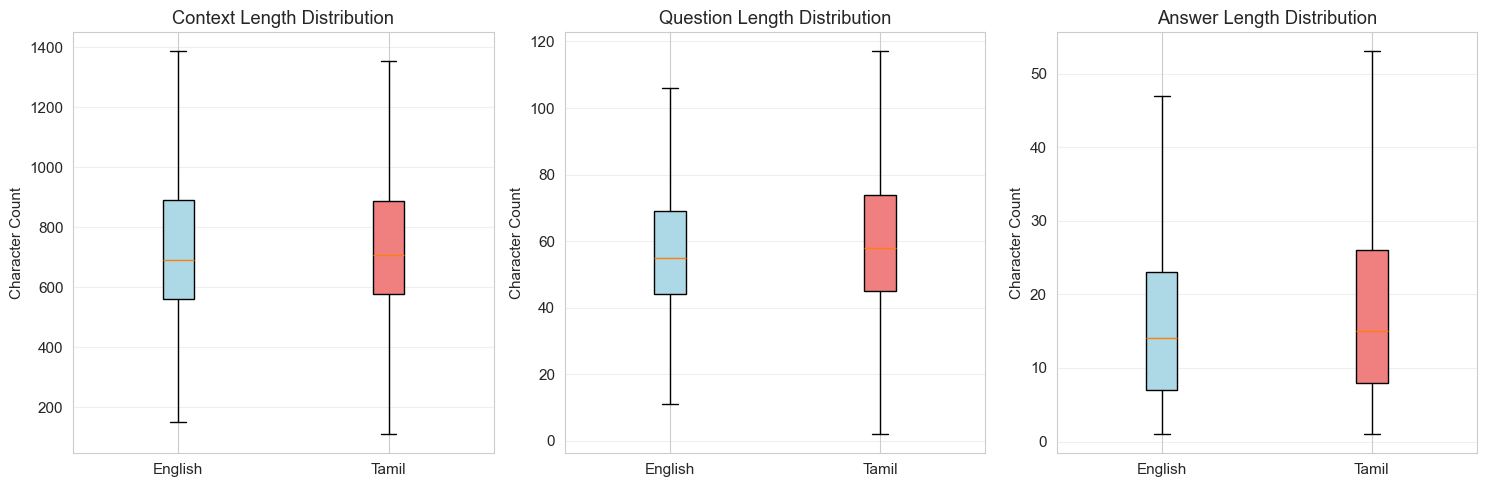

✅ Saved: fig2_translation_ratios.png


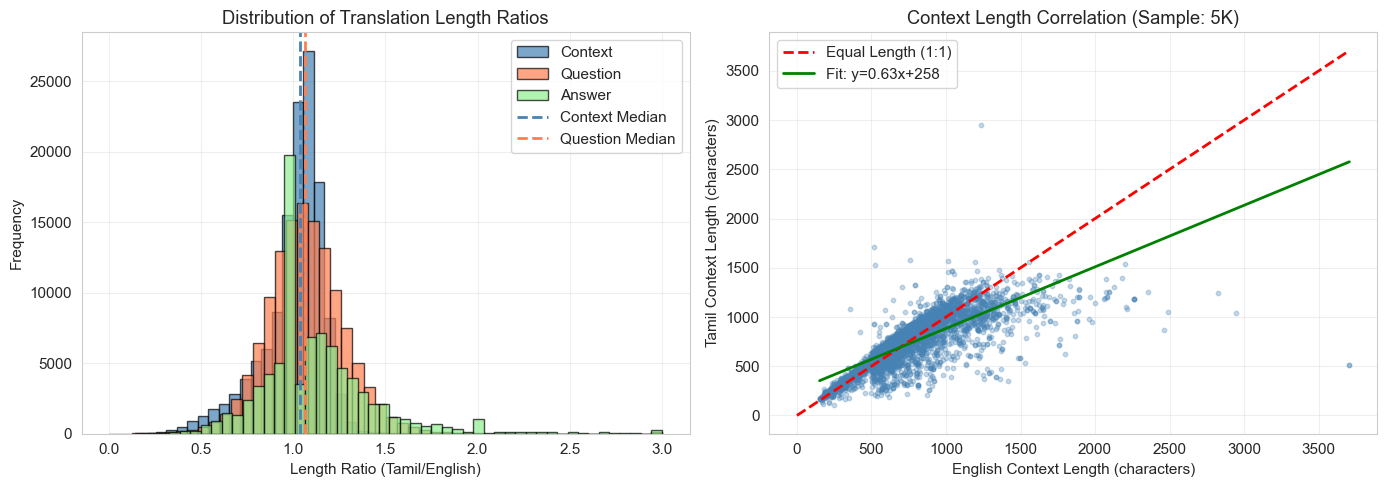


SUMMARY STATISTICS FOR PAPER

          Metric  English Mean  Tamil Mean  Ratio (Ta/En)
 Context Length    754.566287  730.593006       1.002055
Question Length     58.507739   62.272071       1.079474
  Answer Length     20.149727   22.447837       1.144859



In [3]:
"""
Machine Translation Analysis Visualizations
Compares English SQuAD vs Tamil Translated SQuAD
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for publication-quality graphs
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

# Load your translated data
df = pd.read_csv('squad2_train_tamil_complete.csv')

# Calculate lengths
df['context_len_en'] = df['context'].str.len()
df['context_len_ta'] = df['context_tamil'].str.len()
df['question_len_en'] = df['question'].str.len()
df['question_len_ta'] = df['question_tamil'].str.len()
df['answer_len_en'] = df['answer_text'].str.len()
df['answer_len_ta'] = df['answer_text_tamil'].str.len()

# Calculate ratios
df['context_ratio'] = df['context_len_ta'] / df['context_len_en']
df['question_ratio'] = df['question_len_ta'] / df['question_len_en']
df['answer_ratio'] = df['answer_len_ta'] / df['answer_len_en']

print("=" * 80)
print("TRANSLATION STATISTICS")
print("=" * 80)
print(f"\nDataset size: {len(df):,} samples")
print(f"\nMean Length Ratios (Tamil/English):")
print(f"  Context:  {df['context_ratio'].mean():.3f}x")
print(f"  Question: {df['question_ratio'].mean():.3f}x")
print(f"  Answer:   {df['answer_ratio'].mean():.3f}x")

# ============================================================================
# GRAPH 1: Length Distribution Comparison (Box Plots)
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Context lengths
data_context = [
    df['context_len_en'].dropna(),
    df['context_len_ta'].dropna()
]
bp1 = axes[0].boxplot(data_context, labels=['English', 'Tamil'], 
                       patch_artist=True, showfliers=False)
bp1['boxes'][0].set_facecolor('lightblue')
bp1['boxes'][1].set_facecolor('lightcoral')
axes[0].set_ylabel('Character Count')
axes[0].set_title('Context Length Distribution')
axes[0].grid(axis='y', alpha=0.3)

# Question lengths
data_question = [
    df['question_len_en'].dropna(),
    df['question_len_ta'].dropna()
]
bp2 = axes[1].boxplot(data_question, labels=['English', 'Tamil'],
                       patch_artist=True, showfliers=False)
bp2['boxes'][0].set_facecolor('lightblue')
bp2['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Character Count')
axes[1].set_title('Question Length Distribution')
axes[1].grid(axis='y', alpha=0.3)

# Answer lengths
data_answer = [
    df['answer_len_en'].dropna(),
    df['answer_len_ta'].dropna()
]
bp3 = axes[2].boxplot(data_answer, labels=['English', 'Tamil'],
                       patch_artist=True, showfliers=False)
bp3['boxes'][0].set_facecolor('lightblue')
bp3['boxes'][1].set_facecolor('lightcoral')
axes[2].set_ylabel('Character Count')
axes[2].set_title('Answer Length Distribution')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig1_length_distributions.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: fig1_length_distributions.png")
plt.show()

# ============================================================================
# GRAPH 2: Translation Length Ratio Analysis
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram of length ratios
axes[0].hist(df['context_ratio'].clip(0, 3), bins=50, alpha=0.7, 
             label='Context', color='steelblue', edgecolor='black')
axes[0].hist(df['question_ratio'].clip(0, 3), bins=50, alpha=0.7,
             label='Question', color='coral', edgecolor='black')
axes[0].hist(df['answer_ratio'].clip(0, 3), bins=50, alpha=0.7,
             label='Answer', color='lightgreen', edgecolor='black')
axes[0].axvline(df['context_ratio'].median(), color='steelblue', 
                linestyle='--', linewidth=2, label='Context Median')
axes[0].axvline(df['question_ratio'].median(), color='coral',
                linestyle='--', linewidth=2, label='Question Median')
axes[0].set_xlabel('Length Ratio (Tamil/English)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Translation Length Ratios')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Scatter plot (Context length EN vs TA)
sample_size = min(5000, len(df))
sample_df = df.sample(n=sample_size, random_state=42)

axes[1].scatter(sample_df['context_len_en'], sample_df['context_len_ta'],
                alpha=0.3, s=10, color='steelblue')
# Add diagonal line (y=x)
max_val = max(df['context_len_en'].max(), df['context_len_ta'].max())
axes[1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, 
             label='Equal Length (1:1)')
# Add regression line
z = np.polyfit(sample_df['context_len_en'], sample_df['context_len_ta'], 1)
p = np.poly1d(z)
axes[1].plot(sample_df['context_len_en'].sort_values(), 
             p(sample_df['context_len_en'].sort_values()),
             'g-', linewidth=2, label=f'Fit: y={z[0]:.2f}x+{z[1]:.0f}')
axes[1].set_xlabel('English Context Length (characters)')
axes[1].set_ylabel('Tamil Context Length (characters)')
axes[1].set_title('Context Length Correlation (Sample: 5K)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fig2_translation_ratios.png', dpi=300, bbox_inches='tight')
print("✅ Saved: fig2_translation_ratios.png")
plt.show()

# ============================================================================
# SUMMARY STATISTICS TABLE
# ============================================================================
print("\n" + "=" * 80)
print("SUMMARY STATISTICS FOR PAPER")
print("=" * 80)

stats_summary = pd.DataFrame({
    'Metric': ['Context Length', 'Question Length', 'Answer Length'],
    'English Mean': [
        df['context_len_en'].mean(),
        df['question_len_en'].mean(),
        df['answer_len_en'].mean()
    ],
    'Tamil Mean': [
        df['context_len_ta'].mean(),
        df['question_len_ta'].mean(),
        df['answer_len_ta'].mean()
    ],
    'Ratio (Ta/En)': [
        df['context_ratio'].mean(),
        df['question_ratio'].mean(),
        df['answer_ratio'].mean()
    ]
})

print("\n", stats_summary.to_string(index=False))
print("\n" + "=" * 80)